In [1]:
import math
import pandas as pd
import numpy as nm
import nltk
# nltk.download('punkt', download_dir=r'C:\Users\HP\Desktop\ML')
nltk.data.path.append(r'C:\Users\HP\Desktop\ML')
# nltk.download('stopwords',download_dir=r'C:\Users\HP\Desktop\ML')
nltk.data.path.append(r'C:\Users\HP\Desktop\ML')
from collections import defaultdict
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords

from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
senti_df=pd.read_csv("twitter_training.csv")
senti2_df=pd.read_csv("twitter_validation.csv")

In [3]:
sent_df=senti_df.drop(columns=["2401","Borderlands"])
sent2_df=senti2_df.drop(columns=["3364","Facebook"])

In [4]:
sent_df.rename(columns={'Positive': 'sentiment', 'im getting on borderlands and i will murder you all ,': 'text'},inplace=True)
sent2_df.rename(columns={
        'I mentioned on Facebook that I was struggling for motivation to go for a run the other day, which has been translated by Tom’s great auntie as ‘Hayley can’t get out of bed’ and told to his grandma, who now thinks I’m a lazy, terrible person 🤣': 'text'}, inplace=True)
sent2_df.rename(columns={'Irrelevant':'sentiment'},inplace=True)

sent_df['text'] = sent_df['text'].astype(str).replace('nan', '')
sent2_df['text'] = sent2_df['text'].astype(str).replace('nan', '')

In [1]:
class SentimentAnalysisModel:
    def __init__(self):
        self.log_likelihood_positive = {}
        self.log_likelihood_negative = {}
        self.log_likelihood_neutral = {}
        self.log_prior_positive = 0
        self.log_prior_negative = 0
        self.log_prior_neutral = 0
        self.stemmer = PorterStemmer()
        self.stopwords = set(stopwords.words("english"))

    def train(self, training_data):
        word_count_positive = defaultdict(int)
        word_count_negative = defaultdict(int)
        word_count_neutral = defaultdict(int)

        for _, row in training_data.iterrows():
            sentiment = row['sentiment']
            text = row['text']
            tokens = self.prepare(text)
            
            if sentiment == 'Positive':
                for token in tokens:
                    word_count_positive[token] += 1
            elif sentiment == 'Negative':
                for token in tokens:
                    word_count_negative[token] += 1
            elif sentiment == 'Neutral':
                for token in tokens:
                    word_count_neutral[token] += 1

        sum_p = sum(word_count_positive.values())
        sum_n = sum(word_count_negative.values())
        sum_np = sum(word_count_neutral.values())
        
        self.log_likelihood_positive = self.calculate_log_likelihood(word_count_positive, sum_p)
        self.log_likelihood_negative = self.calculate_log_likelihood(word_count_negative, sum_n)
        self.log_likelihood_neutral = self.calculate_log_likelihood(word_count_neutral, sum_np)
        
        self.log_prior_positive = self.calculate_log_prior('Positive', sent_df)
        self.log_prior_negative = self.calculate_log_prior('Negative', sent_df)
        self.log_prior_neutral = self.calculate_log_prior('Neutral', sent_df)

    def prepare(self, text):
        if not isinstance(text, str):
            return []
        tokens = word_tokenize(text)
        tokens = [self.stemmer.stem(token.lower()) for token in tokens if token.lower() not in self.stopwords]
        return tokens

    def calculate_log_likelihood(self, word_count, total_words, laplacian_smoothing=1):
        vocabulary_size = len(word_count)
        return {word: math.log((count + laplacian_smoothing) / (total_words + laplacian_smoothing * vocabulary_size))
                for word, count in word_count.items()}

    def calculate_log_prior(self, sentiment, data):
        count_sentiment = len(data[data['sentiment'] == sentiment])
        total_count = len(data)
        return math.log(count_sentiment / total_count)

   
    def predict(self, tweet):
        tokens = self.prepare(tweet)
        
        log_score_positive = self.log_prior_positive + sum([self.log_likelihood_positive.get(token, 0) for token in tokens])
        log_score_negative = self.log_prior_negative + sum([self.log_likelihood_negative.get(token, 0) for token in tokens])
        log_score_neutral = self.log_prior_neutral + sum([self.log_likelihood_neutral.get(token, 0) for token in tokens])
        
        sentiment_scores = {
            'Positive': log_score_positive,
            'Negative': log_score_negative,
            'Neutral': log_score_neutral
        }
        
        predicted_sentiment = max(sentiment_scores, key=sentiment_scores.get)
        return predicted_sentiment, sentiment_scores, {
            'tokens': tokens,
            'log_priors': {
                'Positive': self.log_prior_positive,
                'Negative': self.log_prior_negative,
                'Neutral': self.log_prior_neutral
            },
            'token_scores': {
                'Positive': [self.log_likelihood_positive.get(token, 0) for token in tokens],
                'Negative': [self.log_likelihood_negative.get(token, 0) for token in tokens],
                'Neutral': [self.log_likelihood_neutral.get(token, 0) for token in tokens]
            }
        }

    def validate(self, validation_data):
        true_labels = []
        predicted_labels = []
        
        for i, (_, row) in enumerate(validation_data.iterrows()):
            true_sentiment = row['sentiment']
            text = row['text']
            predicted_sentiment, scores, details = self.predict(text)
            
            true_labels.append(true_sentiment)
            predicted_labels.append(predicted_sentiment)
            
            if i < 5: 
                print(f"\nText: {text[:50]}...")
                print(f"True sentiment: {true_sentiment}")
                print(f"Predicted sentiment: {predicted_sentiment}")
                print(f"Scores: {scores}")
                print(f"Tokens: {details['tokens'][:10]}...")  # Print first 10 tokens
        
        accuracy = accuracy_score(true_labels, predicted_labels)
        precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predicted_labels, average='weighted')
        
        # Computing the confusion matrix
        cm = confusion_matrix(true_labels, predicted_labels, labels=['Positive', 'Negative', 'Neutral'])
        
        # Computing the  per-class metrics
        per_class_metrics = precision_recall_fscore_support(true_labels, predicted_labels, labels=['Positive', 'Negative', 'Neutral'])

        return {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'confusion_matrix': cm,
            'per_class_metrics': {
                'Positive': {'precision': per_class_metrics[0][0], 'recall': per_class_metrics[1][0], 'f1': per_class_metrics[2][0], 'support': per_class_metrics[3][0]},
                'Negative': {'precision': per_class_metrics[0][1], 'recall': per_class_metrics[1][1], 'f1': per_class_metrics[2][1], 'support': per_class_metrics[3][1]},
                'Neutral': {'precision': per_class_metrics[0][2], 'recall': per_class_metrics[1][2], 'f1': per_class_metrics[2][2], 'support': per_class_metrics[3][2]}
            }
        }
    
    def plot_confusion_matrix(self, cm):
        plt.figure(figsize=(10,7))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title('Confusion Matrix')
        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        plt.show()
        

In [8]:
def analyze_predictions(model, data, n_samples=10):
        for _, row in data.sample(n=n_samples).iterrows():
            text = row['text']
            true_sentiment = row['sentiment']
            predicted_sentiment, scores, details = model.predict(text)
            
            print(f"\nText: {text[:100]}...")
            print(f"True sentiment: {true_sentiment}")
            print(f"Predicted sentiment: {predicted_sentiment}")
            print(f"Scores: {scores}")
            print("Token scores:")
            for sentiment in ['Positive', 'Negative', 'Neutral']:
                print(f"  {sentiment}: {details['token_scores'][sentiment]}")
    
           


Text: BBC News - Amazon boss Jeff Bezos rejects claims c...
True sentiment: Neutral
Predicted sentiment: Negative
Scores: {'Positive': -113.21828453978434, 'Negative': -108.16308585876592, 'Neutral': -136.34861757688168}
Tokens: ['bbc', 'news', '-', 'amazon', 'boss', 'jeff', 'bezo', 'reject', 'claim', 'compani']...

Text: @Microsoft Why do I pay for WORD when it functions...
True sentiment: Negative
Predicted sentiment: Positive
Scores: {'Positive': -46.62256435202798, 'Negative': -74.12040126085653, 'Neutral': -67.23380351560296}
Tokens: ['@', 'microsoft', 'pay', 'word', 'function', 'poorli', '@', 'samsungu', 'chromebook', '?']...

Text: CSGO matchmaking is so full of closet hacking, it'...
True sentiment: Negative
Predicted sentiment: Neutral
Scores: {'Positive': -61.393690578773885, 'Negative': -75.99170754240724, 'Neutral': -60.61865834176746}
Tokens: ['csgo', 'matchmak', 'full', 'closet', 'hack', ',', "'s", 'truli', 'aw', 'game']...

Text: Now the President is slapping Americans 

C:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation Results: {'accuracy': 0.1941941941941942, 'precision': 0.14468475217855717, 'recall': 0.1941941941941942, 'f1_score': 0.16058190318198273, 'confusion_matrix': array([[ 77, 124,  76],
       [114, 100,  52],
       [107, 161,  17]], dtype=int64), 'per_class_metrics': {'Positive': {'precision': 0.21212121212121213, 'recall': 0.2779783393501805, 'f1': 0.240625, 'support': 277}, 'Negative': {'precision': 0.2127659574468085, 'recall': 0.37593984962406013, 'f1': 0.2717391304347826, 'support': 266}, 'Neutral': {'precision': 0.10240963855421686, 'recall': 0.05964912280701754, 'f1': 0.07538802660753881, 'support': 285}}}


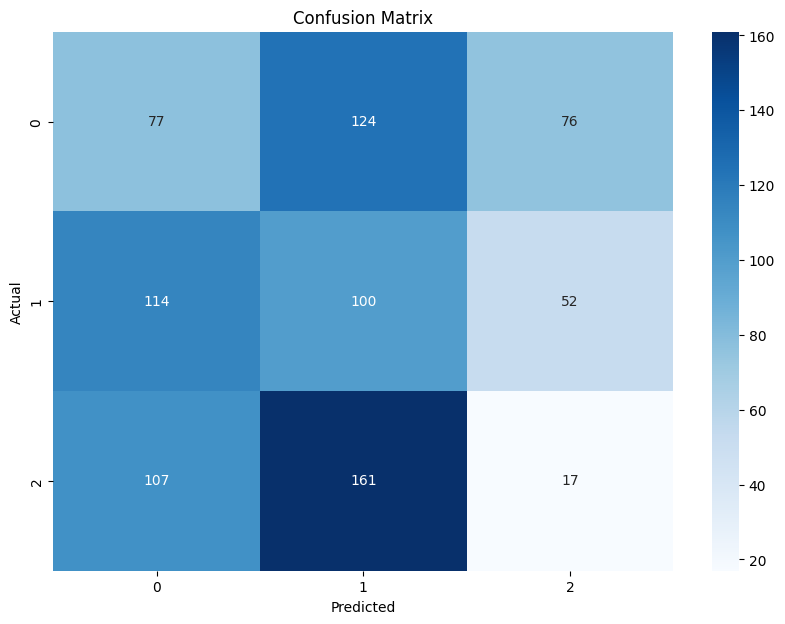

In [9]:

Model = SentimentAnalysisModel()
Model.train(sent_df)
validation_results = Model.validate(sent2_df)
print("Validation Results:", validation_results)
Model.plot_confusion_matrix(validation_results['confusion_matrix'])

In [10]:
analyze_predictions(Model, sent2_df)


Text: borderlands 3 is so good...
True sentiment: Positive
Predicted sentiment: Positive
Scores: {'Positive': -18.137443868893396, 'Negative': -20.758851581339872, 'Neutral': -20.299019221550186}
Token scores:
  Positive: [-5.967104335108804, -5.7203291792613165, -5.173226907275194]
  Negative: [-6.927729532906464, -6.298923069111968, -6.334353506091468]
  Neutral: [-6.673971377784477, -6.0724913857503555, -6.147214931946292]

Text: @googlechrome Every time I open Google Keep, it crashes Chrome. Super annoying. Trying to add to my ...
True sentiment: Negative
Predicted sentiment: Neutral
Scores: {'Positive': -110.74592073909425, 'Negative': -115.418421335116, 'Neutral': -110.26270558697256}
Token scores:
  Positive: [-3.867487260393709, 0, -6.98108579543743, -5.522557876958168, -7.823402325474429, -6.95886265865272, -7.091870901906169, -3.6261349991064424, -8.69713344292979, -10.083427804049679, -2.7358596685479712, -6.88135909749786, -9.310237915816197, -2.7358596685479712, -7.113013

In [11]:
print("\nDetailed Metrics:")
for sentiment in ['Positive', 'Negative', 'Neutral']:
    metrics = validation_results['per_class_metrics'][sentiment]
    print(f"\n{sentiment}:")
    print(f"  Precision: {metrics['precision']:.4f}")
    print(f"  Recall: {metrics['recall']:.4f}")
    print(f"  F1-score: {metrics['f1']:.4f}")
    print(f"  Support: {metrics['support']}")

print(f"\nOverall Accuracy: {validation_results['accuracy']:.4f}")


Detailed Metrics:

Positive:
  Precision: 0.2121
  Recall: 0.2780
  F1-score: 0.2406
  Support: 277

Negative:
  Precision: 0.2128
  Recall: 0.3759
  F1-score: 0.2717
  Support: 266

Neutral:
  Precision: 0.1024
  Recall: 0.0596
  F1-score: 0.0754
  Support: 285

Overall Accuracy: 0.1942
